In [1]:
# !pip install yfinance tensorflow

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import math

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [4]:
stock = yf.download("TSLA", start="2018-01-01", end="2023-12-31")

/tmp/ipython-input-3516239883.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download("TSLA", start="2018-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed


In [5]:
data = stock[['Close']]
print(stock.head())

Price           Close       High        Low       Open     Volume
Ticker           TSLA       TSLA       TSLA       TSLA       TSLA
Date                                                             
2018-01-02  21.368668  21.474001  20.733334  20.799999   65283000
2018-01-03  21.150000  21.683332  21.036667  21.400000   67822500
2018-01-04  20.974667  21.236668  20.378668  20.858000  149194500
2018-01-05  21.105333  21.149332  20.799999  21.108000   68868000
2018-01-08  22.427334  22.468000  21.033333  21.066668  147891000


In [6]:
print(data.head())

Price           Close
Ticker           TSLA
Date                 
2018-01-02  21.368668
2018-01-03  21.150000
2018-01-04  20.974667
2018-01-05  21.105333
2018-01-08  22.427334


In [15]:
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [17]:
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


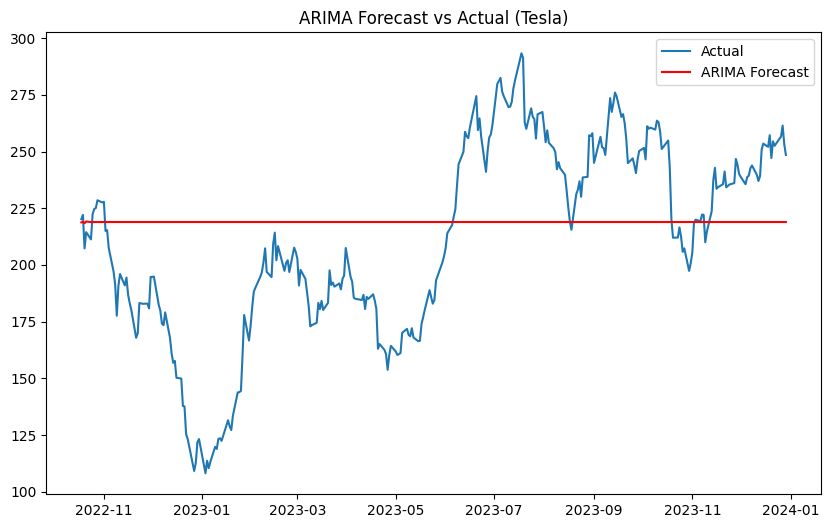

In [18]:
forecast = model_fit.forecast(steps=len(test))
plt.figure(figsize=(10,6))
plt.plot(test.index, test['Close'], label="Actual")
plt.plot(test.index, forecast, label="ARIMA Forecast", color="red")
plt.title("ARIMA Forecast vs Actual (Tesla)")
plt.legend()
plt.show()

In [19]:
rmse_arima = math.sqrt(mean_squared_error(test['Close'], forecast))
print("ARIMA RMSE:", rmse_arima)

ARIMA RMSE: 43.249796780935256


LSTM

In [20]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [23]:
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size-60:]

In [24]:
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [25]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [26]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

In [28]:
model_lstm.fit(x_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.0410
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0044
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0037
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0032
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0033
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0031
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0028
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0023
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0025
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0024
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0027
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0024
Epoch 13/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0023
Epoch 14/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0022
Epoch 15/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0024
Epoc

In [29]:
x_test, y_test = [], []
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

In [30]:
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [31]:
predictions = model_lstm.predict(x_test)
predictions = scaler.inverse_transform(predictions)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


In [32]:
rmse_lstm = math.sqrt(mean_squared_error(data['Close'][-len(predictions):], predictions))
print("LSTM RMSE:", rmse_lstm)

LSTM RMSE: 13.192605137813594


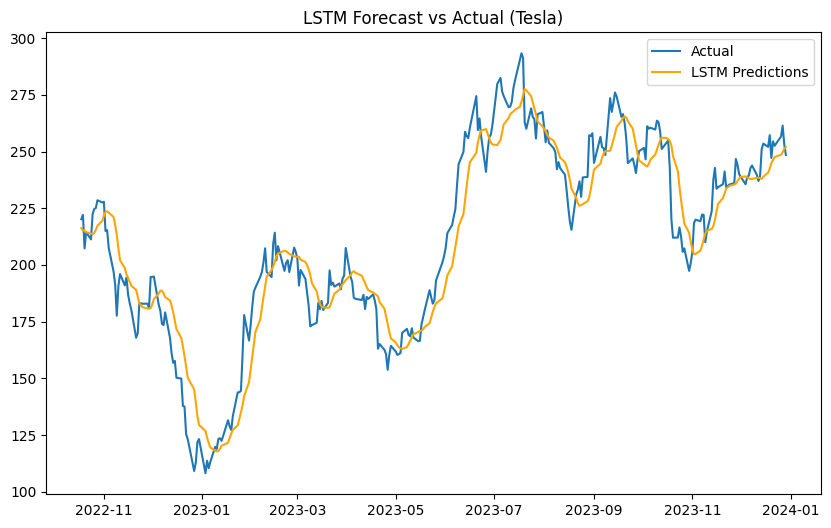

In [33]:
plt.figure(figsize=(10,6))
plt.plot(data.index[-len(predictions):], data['Close'][-len(predictions):], label="Actual")
plt.plot(data.index[-len(predictions):], predictions, label="LSTM Predictions", color="orange")
plt.title("LSTM Forecast vs Actual (Tesla)")
plt.legend()
plt.show()